In [4]:
# Spark init
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [5]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Create spark session 
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [8]:
# Check raw data (reviews.csv)
!head -5 /content/drive/MyDrive/data/beers-breweries-reviews/reviews.csv

beer_id,username,date,text,look,smell,taste,feel,overall,score
271781,bluejacket74,2017-03-17,"   750 ml bottle, 2016 vintage, bottle #304 of 360. Served in a DFH snifter, the beer pours dark brown/black with about an inch tan head that stuck around a little while. There's also a good amount of lacing. I like the aroma, the brew smells like dark fruit (raisin, plum), chocolate, roasted malt, and a bit of licorice. For the most part I think the taste is just like the aroma, but with some coffee flavor noticeable too. Mouthfeel/body is medium/full, it's creamy and coating with a moderate amount of carbonation. I think it's a good overall brew, worth picking up if you want a nice straight forward imperial stout. Here's hoping Four String brings this back in the future! $9.99 a bottle.  ",4,4,4,4.25,4,4.03
125646,_dirty_,2017-12-21,  ,4.5,4.5,4.5,4.5,4.5,4.5
125646,CJDUBYA,2017-12-21,  ,4.75,4.75,4.75,4.75,4.75,4.75
125646,GratefulBeerGuy,2017-12-20,"   0% 16 oz can. Funny story: As I fina

In [59]:
# Create the schema, read the reviews file, and display top 20 rows
reviews_custom_schema = StructType([
        StructField("beer_id", IntegerType(), True),
        StructField("username", StringType(), True),
        StructField("date", DateType(), True),
        StructField("review_text", StringType(), True),
        StructField("look", FloatType(), True),
        StructField("smell", FloatType(), True),
        StructField("taste", FloatType(), True),
        StructField("feel", FloatType(), True),
        StructField("overall", FloatType(), True),
        StructField("score", FloatType(), True)
  ])

reviews_df = spark.read.csv('/content/drive/MyDrive/data/beers-breweries-reviews/reviews.csv',
                    sep = ',', schema = reviews_custom_schema, header = True)

reviews_df.show()

+-------+---------------+----------+--------------------+----+-----+-----+----+-------+-----+
|beer_id|       username|      date|         review_text|look|smell|taste|feel|overall|score|
+-------+---------------+----------+--------------------+----+-----+-----+----+-------+-----+
| 271781|   bluejacket74|2017-03-17|   750 ml bottle,...| 4.0|  4.0|  4.0|4.25|    4.0| 4.03|
| 125646|        _dirty_|2017-12-21|                    | 4.5|  4.5|  4.5| 4.5|    4.5|  4.5|
| 125646|        CJDUBYA|2017-12-21|                    |4.75| 4.75| 4.75|4.75|   4.75| 4.75|
| 125646|GratefulBeerGuy|2017-12-20|"   0% 16 oz can....|null| null| null|null|   null| null|
| 125646|       LukeGude|2017-12-20|   Classic TH NEI...|4.25|  4.5| 4.25|4.25|   4.25| 4.31|
| 125646|        jneff33|2017-12-20|                    | 4.5| 4.75|  5.0| 5.0|    5.0| 4.91|
| 125646|      yummybeer|2017-12-19|                    |4.75|  4.5| 4.75|4.75|   4.75| 4.69|
| 125646|           MFMB|2017-12-16|   Pours a creamy...|4.7

In [10]:
reviews_df.printSchema()

root
 |-- beer_id: integer (nullable = true)
 |-- username: string (nullable = true)
 |-- date: date (nullable = true)
 |-- review_text: string (nullable = true)
 |-- look: float (nullable = true)
 |-- smell: float (nullable = true)
 |-- taste: float (nullable = true)
 |-- feel: float (nullable = true)
 |-- overall: float (nullable = true)
 |-- score: float (nullable = true)



In [11]:
# Drop unnecessary columns, remove rows with missing values, and create clean df
clean_reviews_df = reviews_df.drop('date', 'review_text')
clean_reviews_df = clean_reviews_df.dropna()

clean_reviews_df.show()

+-------+------------+----+-----+-----+----+-------+-----+
|beer_id|    username|look|smell|taste|feel|overall|score|
+-------+------------+----+-----+-----+----+-------+-----+
| 271781|bluejacket74| 4.0|  4.0|  4.0|4.25|    4.0| 4.03|
| 125646|     _dirty_| 4.5|  4.5|  4.5| 4.5|    4.5|  4.5|
| 125646|     CJDUBYA|4.75| 4.75| 4.75|4.75|   4.75| 4.75|
| 125646|    LukeGude|4.25|  4.5| 4.25|4.25|   4.25| 4.31|
| 125646|     jneff33| 4.5| 4.75|  5.0| 5.0|    5.0| 4.91|
| 125646|   yummybeer|4.75|  4.5| 4.75|4.75|   4.75| 4.69|
| 125646|        MFMB|4.75|  4.5|  4.5| 4.5|    4.5| 4.52|
| 125646|        wwoj| 5.0| 4.75|  4.5| 4.5|    4.5| 4.59|
| 125646|     Rubenjr|4.75|  4.5|  4.5|4.75|    4.5| 4.54|
| 125646|      jshusc| 4.5| 4.75|  4.5| 4.5|    4.5| 4.56|
| 125646|    wfreitag|4.75| 4.75| 4.75|4.75|   4.75| 4.75|
| 125646|   RollTide7| 4.5|  4.5| 4.75| 4.5|   4.75| 4.65|
| 125646| jngrizzaffi| 4.5|  4.5|  4.5|4.75|    4.5| 4.53|
| 125646| MBruckerATC| 5.0|  5.0|  5.0| 5.0|    5.0|  5.

In [12]:
# Number of unique users
uniqueUsers = clean_reviews_df.select('username').distinct().count()
print("There are %d unique users that left a review." % uniqueUsers)

# Number of unique beers 
uniqueBeers = clean_reviews_df.select('beer_id').distinct().count()
print("There are %d beers that were reviewed." % uniqueBeers)

There are 108406 unique users that left a review.
There are 155199 beers that were reviewed.


In [13]:
# Find average ratings for all categories 
# This takes a long time to run (about 10 minutes)
import pyspark.sql.functions as func

averageLookRating = clean_reviews_df.agg(func.avg('look')).collect()[0][0]
print("The average rating for the Look category is: %.2f" % averageLookRating)

averageSmellRating = clean_reviews_df.agg(func.avg('smell')).collect()[0][0]
print("The average rating for the Smell category is: %.2f" % averageSmellRating) 

averageTasteRating = clean_reviews_df.agg(func.avg('taste')).collect()[0][0]
print("The average rating for the Taste category is: %.2f" % averageTasteRating) 

averageFeelRating = clean_reviews_df.agg(func.avg('feel')).collect()[0][0]
print("The average rating for the Feel category is: %.2f" % averageFeelRating) 

averageOverallRating = clean_reviews_df.agg(func.avg('overall')).collect()[0][0]
print("The average rating for the Overall category is: %.2f" % averageOverallRating)

averageScoreRating = clean_reviews_df.agg(func.avg('score')).collect()[0][0]
print("The average rating for the Score category is: %.2f" % averageScoreRating)

The average rating for the Look category is: 3.96
The average rating for the Smell category is: 3.89
The average rating for the Taste category is: 3.93
The average rating for the Feel category is: 3.89
The average rating for the Overall category is: 3.92
The average rating for the Score category is: 3.92


In [14]:
# Check raw data (beers.csv)
!head -5 /content/drive/MyDrive/data/beers-breweries-reviews/beers.csv

id,name,brewery_id,state,country,style,availability,abv,notes,retired
202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout, Rotating,7.3,No notes at this time.,f
82352,Konrads Stout Russian Imperial Stout,18604,,NO,Russian Imperial Stout, Rotating,10.4,No notes at this time.,f
214879,Scottish Right,44306,IN,US,Scottish Ale, Year-round,4,No notes at this time.,t
320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout, Winter,8.7,Every time this year,f


In [60]:
# Create the schema, read the beers file, and display top 20 rows
beers_custom_schema = StructType([
        StructField("beer_id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("brewery_id", IntegerType(), True),
        StructField("state", StringType(), True),
        StructField("country", StringType(), True),
        StructField("style", StringType(), True),
        StructField("availability", StringType(), True),
        StructField("abv", FloatType(), True),
        StructField("notes", StringType(), True),
        StructField("retired", StringType(), True)
  ])
beers_df = spark.read.csv('/content/drive/MyDrive/data/beers-breweries-reviews/beers.csv',
                    sep = ',', schema = beers_custom_schema, header = True)

beers_df.show()

+-------+--------------------+----------+-----+-------+--------------------+--------------------+----+--------------------+-------+
|beer_id|                name|brewery_id|state|country|               style|        availability| abv|               notes|retired|
+-------+--------------------+----------+-----+-------+--------------------+--------------------+----+--------------------+-------+
| 202522|      Olde Cogitator|      2199|   CA|     US|English Oatmeal S...|            Rotating| 7.3|No notes at this ...|      f|
|  82352|Konrads Stout Rus...|     18604| null|     NO|Russian Imperial ...|            Rotating|10.4|No notes at this ...|      f|
| 214879|      Scottish Right|     44306|   IN|     US|        Scottish Ale|          Year-round| 4.0|No notes at this ...|      t|
| 320009|MegaMeow Imperial...|      4378|   WA|     US|American Imperial...|              Winter| 8.7|Every time this year|      f|
| 246438|     Peaches-N-Cream|     44617|   PA|     US|  American Cream Ale|

In [16]:
beers_df.printSchema()

root
 |-- beer_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- brewery_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- style: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- abv: float (nullable = true)
 |-- notes: string (nullable = true)
 |-- retired: string (nullable = true)



In [40]:
# Drop unnecessary columns, change null values in state column to blank, and create clean df
clean_beers_df = beers_df.drop('style', 'availability','notes', 'retired')

clean_beers_df = clean_beers_df.fillna("", ['state'])

clean_beers_df.show(truncate=False)

+-------+-------------------------------------+----------+-----+-------+----+
|beer_id|name                                 |brewery_id|state|country|abv |
+-------+-------------------------------------+----------+-----+-------+----+
|202522 |Olde Cogitator                       |2199      |CA   |US     |7.3 |
|82352  |Konrads Stout Russian Imperial Stout |18604     |     |NO     |10.4|
|214879 |Scottish Right                       |44306     |IN   |US     |4.0 |
|320009 |MegaMeow Imperial Stout              |4378      |WA   |US     |8.7 |
|246438 |Peaches-N-Cream                      |44617     |PA   |US     |5.1 |
|8036   |World Burp Beer 2002                 |3469      |     |JP     |5.5 |
|108605 |Icon Sender                          |22598     |CA   |US     |5.6 |
|345382 |Divina IPA                           |45567     |     |IT     |6.5 |
|255286 |Light Of The Ozarks                  |11203     |AR   |US     |4.3 |
|29556  |Warrior's Bock                       |8203      |SK   |

In [42]:
# Show the number of beers brewed in the US
clean_beers_df.filter(clean_beers_df.country=='US').count()

265458

In [41]:
# Show the number of beers brewed outside of the US
clean_beers_df.filter(clean_beers_df.country!='US').count()

93280

In [18]:
# Show the top 10 reported beers with the highest alcohol by volume in descending order 
highestABV = clean_beers_df.select('beer_id', 'name', 'abv').sort(func.col('abv').desc())
highestABV.show(10)

+-------+--------------------+-----+
|beer_id|                name|  abv|
+-------+--------------------+-----+
| 365307|               water|100.0|
| 368012|Radiohead - OK Co...|100.0|
| 368014|Earache: World's ...|100.0|
| 311921|      Dark Reckoning| 80.0|
| 104620|         Snake Venom| 67.5|
| 366894|            series 3| 66.0|
|  89801|          Armageddon| 65.0|
|  83277|    Start The Future| 60.0|
|  73368|Schorschbräu Scho...| 57.5|
| 340204|    Belgian Pale Ale| 56.0|
+-------+--------------------+-----+
only showing top 10 rows



In [19]:
# Show the top 10 reported beers with the lowest alcohol by volume in ascending order 
beers_with_abv = clean_beers_df.dropna(subset='abv') #remove beers without any value for abv
lowestABV = beers_with_abv.select('beer_id', 'name', 'abv').sort(func.col('abv').asc())
lowestABV.show(10)

+-------+------------------+----+
|beer_id|              name| abv|
+-------+------------------+----+
| 281191|      Innis & None|0.01|
|  48553|            Chello|0.01|
|  75417| Bavaria 0,0% Rosé|0.01|
|  20210|             Liber|0.01|
| 234948|           Día Sin|0.04|
|   5898|         Vuurtoren|0.05|
|  11198|        Genesee NA|0.05|
|  78062|Birra Moretti Zero|0.05|
|   5872|      Bavaria Malt|0.05|
|  77292|       Scotty K NA|0.05|
+-------+------------------+----+
only showing top 10 rows



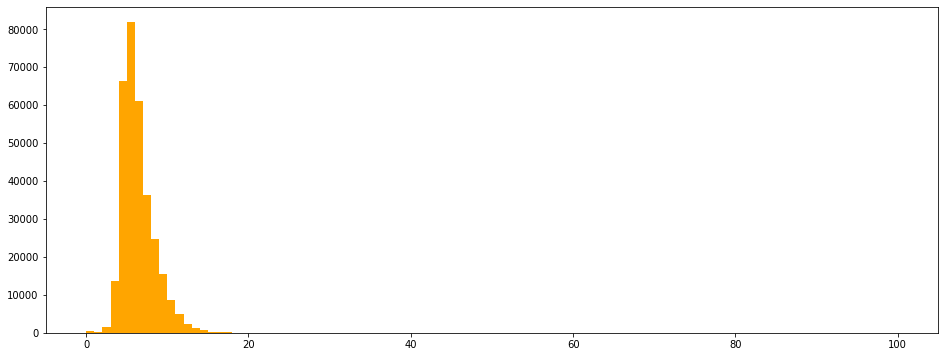

In [57]:
import matplotlib
import matplotlib.pyplot as plt

beerABV = beers_with_abv.select('abv').collect()

beerABV_list = []
beerABV_len = len(beerABV)
for i in range(0, beerABV_len): 
    beerABV_list.append(beerABV[i].abv)
plt.hist(beerABV_list, bins=100, color='orange') 
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
plt.show()

In [58]:
# Check raw data (breweries.csv)
!head -5 /content/drive/MyDrive/data/beers-breweries-reviews/breweries.csv

id,name,city,state,country,notes,types
19730,Brouwerij Danny,Erpe-Mere,,BE,No notes at this time.,Brewery
32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store


In [64]:
# Read the breweries file and display top 20 rows

breweries_custom_schema = StructType([
        StructField("brewery_id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("city", StringType(), True),
        StructField("state", StringType(), True),
        StructField("country", StringType(), True),
        StructField("notes", StringType(), True),
        StructField("types", StringType(), True)
  ])

breweries_df = spark.read.csv('/content/drive/MyDrive/data/beers-breweries-reviews/breweries.csv',
                    sep = ',', schema = breweries_custom_schema, header = True)

breweries_df.show()

+----------+--------------------+--------------------+-----+-------+--------------------+--------------------+
|brewery_id|                name|                city|state|country|               notes|               types|
+----------+--------------------+--------------------+-----+-------+--------------------+--------------------+
|     19730|     Brouwerij Danny|           Erpe-Mere| null|     BE|No notes at this ...|             Brewery|
|     32541|Coachella Valley ...|      Thousand Palms|   CA|     US|No notes at this ...|Brewery, Bar, Bee...|
|     44736|    Beef 'O' Brady's|          Plant City|   FL|     US|No notes at this ...|         Bar, Eatery|
|     23372|Broadway Wine Mer...|       Oklahoma City|   OK|     US|No notes at this ...|               Store|
|     35328|Brighton Beer Dis...|            Brighton|  GB2|     GB|Duplicate of http...|         Bar, Eatery|
|     31561|      Teddy's Tavern|             Seattle|   WA|     US|No notes at this ...|     Bar, Beer-to-go|
|

In [66]:
# Drop unnecessary columns, change null values in state column to blank, and create clean df
clean_breweries_df = breweries_df.drop('notes', 'types')

clean_breweries_df = clean_breweries_df.fillna("", ['state'])

clean_breweries_df.show(truncate=False)

+----------+--------------------------------------------------+-----------------------+-----+-------+
|brewery_id|name                                              |city                   |state|country|
+----------+--------------------------------------------------+-----------------------+-----+-------+
|19730     |Brouwerij Danny                                   |Erpe-Mere              |     |BE     |
|32541     |Coachella Valley Brewing Co                       |Thousand Palms         |CA   |US     |
|44736     |Beef 'O' Brady's                                  |Plant City             |FL   |US     |
|23372     |Broadway Wine Merchant                            |Oklahoma City          |OK   |US     |
|35328     |Brighton Beer Dispensary (DUPLICATE)              |Brighton               |GB2  |GB     |
|31561     |Teddy's Tavern                                    |Seattle                |WA   |US     |
|35975     |Modus Operandi Brewing Co.                        |Mona Vale          

In [71]:
# Number of breweries in the dataset 
breweriesCount = clean_breweries_df.select('brewery_id').count()
print("There are %d number of breweries in our data." % breweriesCount)

There are 50347 number of breweries in our data.


In [96]:
# Number of breweries in each state
state_df = clean_breweries_df.filter(clean_breweries_df.country=='US')
state_count = state_df.groupby('state').count().sort('state')
state_count.show(52)

+-----+-----+
|state|count|
+-----+-----+
|     |   33|
|   AK|  117|
|   AL|  240|
|   AR|  115|
|   AZ|  439|
|   CA| 3638|
|   CO| 1007|
|   CT|  692|
|   DC|  203|
|   DE|  204|
|   FL| 1595|
|   GA|  636|
|   HI|  127|
|   IA|  319|
|   ID|  182|
|   IL| 1551|
|   IN|  652|
|   KS|  192|
|   KY|  297|
|   LA|  214|
|   MA| 1372|
|   MD|  670|
|   ME|  380|
|   MI| 1134|
|   MN|  951|
|   MO|  536|
|   MS|  111|
|   MT|  130|
|   NC| 1301|
|   ND|   61|
|   NE|  170|
|   NH|  319|
|   NJ|  959|
|   NM|  176|
|   NV|  237|
|   NY| 2284|
|   OH| 1518|
|   OK|  182|
|   OR|  775|
|   PA| 2454|
|   RI|  234|
|   SC|  441|
|   SD|  142|
|   TN|  422|
|   TX| 1342|
|   UT|   93|
|   VA| 1036|
|   VT|  403|
|   WA| 1131|
|   WI|  996|
|   WV|  135|
|   WY|  145|
+-----+-----+



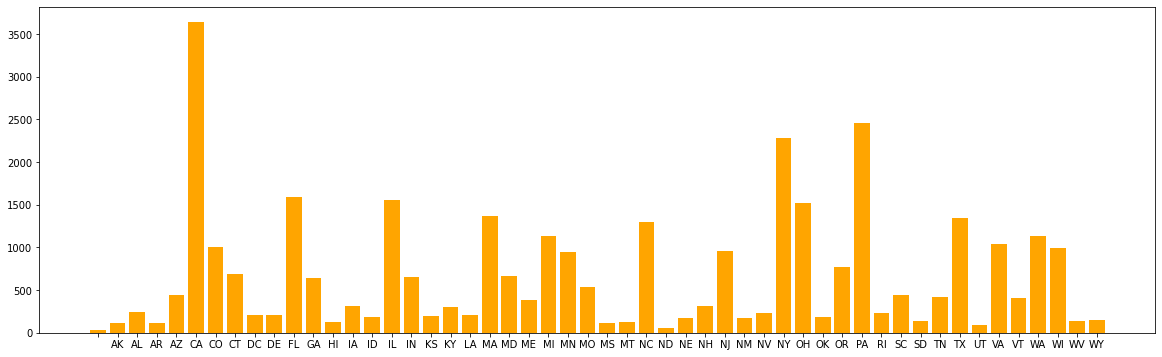

In [102]:
# Breweries per state in the US
dict = state_count.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='orange')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 6)